In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="materialsciencemodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
materialsscienceFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [8]:
materialssciFOSID = materialsscienceFOSID.filter(materialsscienceFOSID["Domain"]=="MaterialScience").collect()

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(materialssciFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+---------------+
|   FOS_ID|         Domain|
+---------+---------------+
|188027245|MaterialScience|
|159985019|MaterialScience|
+---------+---------------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [56]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [57]:
papers_filtered1.count()

4799426

In [58]:
(sample1,sample2) = papers_filtered1.randomSplit([0.3,0.7])

In [59]:
sample1.count()

1439680

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [61]:
sample1_pd = sample1.toPandas()

In [62]:
sample1_pd.columns

Index([u'PaperID', u'EstimatedCount', u'Rank', u'ReferenceCount', u'PaperAge',
       u'IsJournal', u'min_FOSRank', u'max_FOSRank', u'max_FOSPaperCount',
       u'min_FOSPaperCount', u'min_FOSCitationCount', u'max_FOSCitationCount',
       u'PaperRefCnt', u'label'],
      dtype='object')

In [63]:
import numpy as np

In [64]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

In [65]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 1.1620526783729719)
('Mean Squared Error of EstimatedCount:', 662.4387822293843)
('Root Mean Squared of with EstimatedCount:', 25.737886125892008)


In [71]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

In [72]:
from sklearn.model_selection import KFold

In [73]:
y[0:5]

array([3, 2, 7, 4, 8], dtype=int32)

In [74]:
sample1_pd.head(2)

,Rank,ReferenceCount,PaperAge,IsJournal,min_FOSRank,max_FOSRank,max_FOSPaperCount,min_FOSPaperCount,min_FOSCitationCount,max_FOSCitationCount,PaperRefCnt,label
0,23586,4,34,0,7838,14213,8960343,1471,4225,43049958,0,3
1,23276,3,30,0,7838,11794,8960343,5570,33564,49764336,0,2


In [75]:
kf = KFold(n_splits=5)
kf.get_n_splits(X, y)

5

In [76]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [77]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    

('TRAIN:', array([ 287936,  287937,  287938, ..., 1439677, 1439678, 1439679]), 'TEST:', array([     0,      1,      2, ..., 287933, 287934, 287935]))
('Mean Absolute Error:', 2.408161866189057)
('Mean Squared Error:', 91.07079717976261)
('Root Mean Squared Error:', 9.543102073213019)
('TRAIN:', array([      0,       1,       2, ..., 1439677, 1439678, 1439679]), 'TEST:', array([287936, 287937, 287938, ..., 575869, 575870, 575871]))
('Mean Absolute Error:', 4.22766584204813)
('Mean Squared Error:', 1008.0275077752224)
('Root Mean Squared Error:', 31.749448936559865)
('TRAIN:', array([      0,       1,       2, ..., 1439677, 1439678, 1439679]), 'TEST:', array([575872, 575873, 575874, ..., 863805, 863806, 863807]))
('Mean Absolute Error:', 1.2894564096375107)
('Mean Squared Error:', 16.415516145768127)
('Root Mean Squared Error:', 4.051606612909023)
('TRAIN:', array([      0,       1,       2, ..., 1439677, 1439678, 1439679]), 'TEST:', array([ 863808,  863809,  863810, ..., 1151741, 115174

In [79]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 12.016143506442216)


In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
featureslist=sample1_pd.columns

In [82]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.58821
Feature: 1, Score: 0.02218
Feature: 2, Score: 0.28091
Feature: 3, Score: 0.00287
Feature: 4, Score: 0.01704
Feature: 5, Score: 0.02104
Feature: 6, Score: 0.01072
Feature: 7, Score: 0.01809
Feature: 8, Score: 0.01785
Feature: 9, Score: 0.00821
Feature: 10, Score: 0.01289


Text(0.5,1,'Feature Importances')

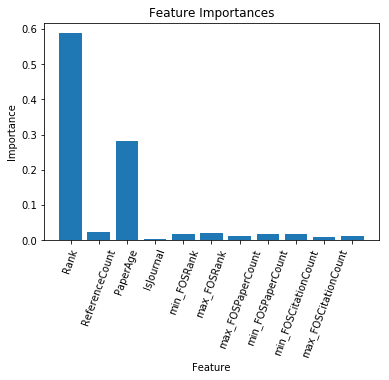

In [55]:
importances = regressor.feature_importances_
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, featureslist[0:10], rotation=70)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [83]:
import pandas as pd

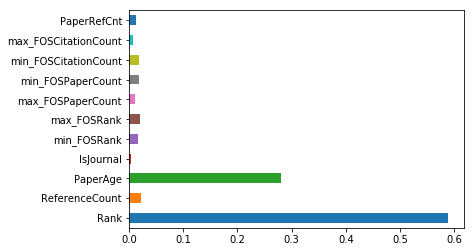

In [84]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

## XGBoost Regression model using KFold

In [88]:
import xgboost as xgb

In [89]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [90]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=30
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 287936,  287937,  287938, ..., 1439677, 1439678, 1439679]), 'TEST:', array([     0,      1,      2, ..., 287933, 287934, 287935]))
('Mean Absolute Error of XGBoost Kfold:', 2.5111461904193444)
('Mean Squared Error of XGBoost Kfold:', 100.54498307353973)
('Root Mean Squared Error of XGBoost Kfold:', 10.027212128679622)
('TRAIN:', array([      0,       1,       2, ..., 1439677, 1439678, 1439679]), 'TEST:', array([287936, 287937, 287938, ..., 575869, 575870, 575871]))
('Mean Absolute Error of XGBoost Kfold:', 4.490979483426358)
('Mean Squared Error of XGBoost Kfold:', 1055.9890207390292)
('Root Mean Squared Error of XGBoost Kfold:', 32.4959846864044)
('TRAIN:', array([      0,       1,       2, ..., 1439677, 1439678, 1439679]), 'TEST:', array([575872, 575873, 575874, ..., 863805, 863806, 863807]))
('Mean Absolute Error of XGBoost Kfold:', 1.316222335662793)
('Mean Squared Error of XGBoost Kfold:', 18.45193791413969)
('Root Mean Squared Error of XGBoost Kfold:', 4.295571

In [91]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 11.649091636656868)


In [92]:
importances = regressor.feature_importances_

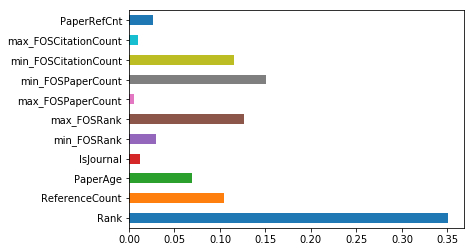

In [93]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 